In [1]:
# Optional: change Jupyter Notebook theme to GDD theme
from IPython.core.display import HTML
HTML(url='https://gdd.li/jupyter-theme')

![footer_logo](images/logo.png)
# Seasonality Modeling


## Goal

During this session we shall focus on modelling Time Series data. 

We shall learn about the different components we can identify in Time Series data and how they can be modelled.

## Program

1. [Time Series Decomposition](#ets)
2. [Linear Modeling Approach](#lma)
3. [Dealing with Seasonality](#dws)
4. [Gradual Seasonal Filtering](#gsf)
6. [Forecast Evaluation for Seasonality Models](#eval)
7. [Summary](#sum)

In [1]:
import calendar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

plt.rcParams['figure.figsize'] = (16,4)

![footer_logo](images/air-quality.jpeg) 


## The Data

We will again use a dataset containing daily air quality index in Californian counties between 2007 and 2017 (based on a larger dataset from [Kaggle](https://www.kaggle.com/epa/carbon-monoxide)). 

Each datapoint indicates the average air quality index on a certain day: the higher the value - the more polluted.


In [2]:
air_df = pd.read_csv('data/air_quality.csv', index_col='date_local', parse_dates=True)
air_df.head()

,aqi
date_local,
2007-08-01,5.522124
2007-08-02,5.894895
2007-08-03,5.928358
2007-08-04,5.792285
2007-08-05,5.744807


By visualising the data we can we can identify some patterns,

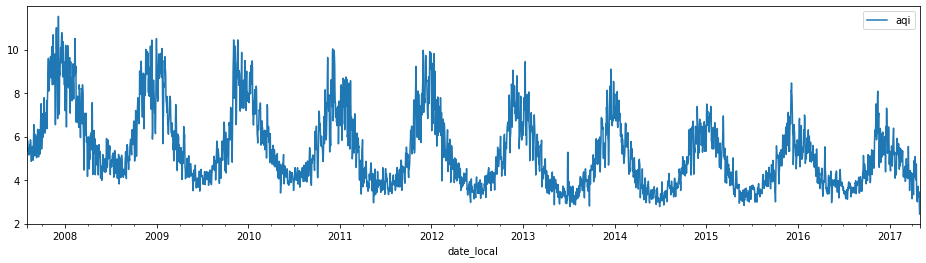

In [3]:
air_df.plot();

These regularities in the data can be categorised as follows:
- **Trends** (upward / horizontal / downward)
- **Seasonality** (predictably repeating cycles - weekly/monthly/yearly etc)
- **Cyclical components** (patterns with no period - for example trend breaks) 
- **Residuals** (the remaining part of the series that cannot be further explicitly modeled)

<a id='ets'></a>
## 1. Time Series decomposition

Seasonality is very common in business data. However, it can obscure the actual signal of the data, which complicates both understanding of the underlying processes and further forecasting. 

Accordingly, we may wish to separate Time Series data into its trend and seasonal components. This process is known as **Time Series decomposition**.

One of the simplest ways to identify the general trend is to substantially **smooth** the Time Series data. For example, the smoothed data clearly suggests a downward trend in AQI (or that air quality is improving).

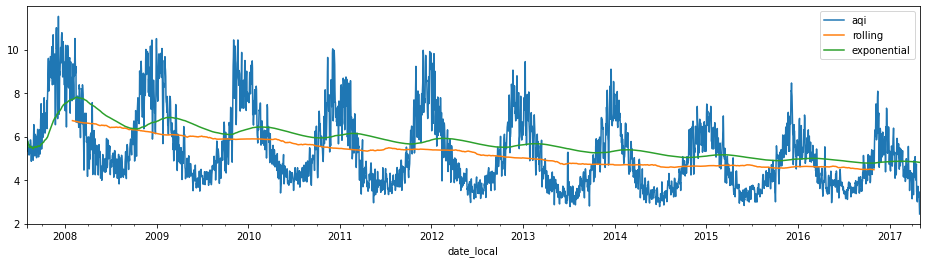

In [4]:
(
    air_df
    .assign(rolling = lambda df: df['aqi'].rolling(365, center=True).mean(),
            exponential=lambda df: df['aqi'].ewm(alpha=0.001).mean()
           )
    .plot()
);

However, whilst smoothing can average out the effects of seasonality and noise, it does not provide us with a mathematical model that can describe the data and be used for forecasting. In addition to this, the "centering" involved in rolling mean makes use of information from the future, which would not be possible in the context of forecasting.


<a id='lma'></a>
## 2. Linear Modeling Approach

An alternative way to identify the main pattern(s) taking place in the data is to fit a linear regression. 

Even the most basic linear model with a single time component can inform us about the general trend and allow us to (mostly) separate it from the seasonality.

To demonstrate this we shall learn a linear regression model that is able to predict the AQI of a particular date.

We shall first create a variable to indicate which number time point the dates represent.

In [5]:
air_df['time_point'] = np.arange(len(air_df))
air_df.head()

,aqi,time_point
date_local,,
2007-08-01,5.522124,0
2007-08-02,5.894895,1
2007-08-03,5.928358,2
2007-08-04,5.792285,3
2007-08-05,5.744807,4


We then separate the data into a feature matrix **X** and target vetor **y** so we can fit a linear regression.

In [6]:
X = air_df[['time_point']]
y = air_df['aqi']

In [7]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

The predictions from this model represents the linear trend.

In [8]:
air_df['linear_trend'] = lm.predict(X)
air_df.sample(10)

,aqi,time_point,linear_trend
date_local,,,
2016-10-03,4.427562,3351,4.264797
2012-01-04,8.805732,1617,5.446585
2007-12-14,10.096154,135,6.456626
2008-12-06,10.155367,493,6.212635
2008-12-28,8.056657,515,6.197641
2009-01-06,8.514535,524,6.191507
2013-05-02,3.951890,2101,5.116721
2013-05-16,3.568421,2115,5.107179
2012-11-12,6.178344,1930,5.233264


Let's visualise the outcome for the model on the data it was trained on.

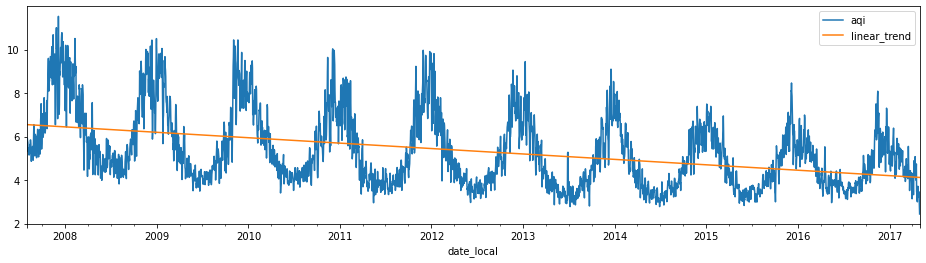

In [9]:
air_df[['aqi','linear_trend']].plot();

As simple as this is, it gives us an idea of what happens over time. 

Of course a single linear trend cannot take dynamical changes in growth/decline rates into account. 

For example the trend appears to change around summer 2014.

<!-- https://en.wikipedia.org/wiki/Hurricane_Marie_(2014) -->

But we can take care of this by adding break indicators & interaction terms:
- The `after_summer_2014` indicator term will allows us to add a particular quantity depending on whether we are before or after the date 01/08/2014.
- The `interaction` term allows to add an additional quantities which are dependent on the time point.


In [10]:
X_break = (
    air_df
    .assign(after_summer_2014 = np.where(air_df.index > pd.Timestamp('2014-08'), 1, 0),
            interaction = lambda df: df['time_point']*df['after_summer_2014'])
    [['time_point', 'after_summer_2014','interaction']]
)
X_break

,time_point,after_summer_2014,interaction
date_local,,,
2007-08-01,0,0,0
2007-08-02,1,0,0
2007-08-03,2,0,0
2007-08-04,3,0,0
2007-08-05,4,0,0
...,...,...,...
2017-04-27,3557,1,3557
2017-04-28,3558,1,3558
2017-04-29,3559,1,3559


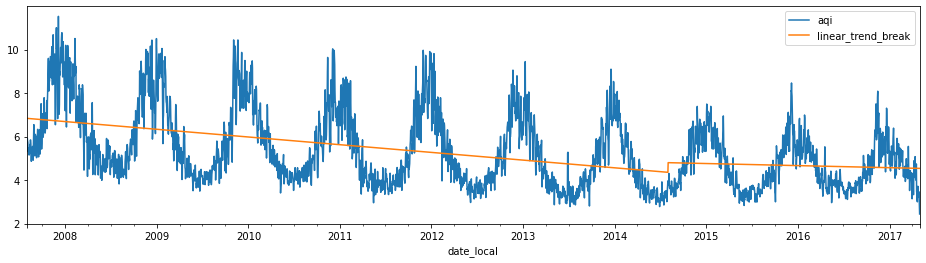

In [11]:
lm_break = LinearRegression().fit(X_break, y)

air_df['linear_trend_break'] = lm_break.predict(X_break)

air_df[['aqi','linear_trend_break']].plot();

In [12]:
# X_break = (
#     air_df
#     .assign(after_summer_2014 = np.where(air_df.index < pd.Timestamp('2014-08'), 1, 0),
#             before_summer_2011 = np.where(air_df.index < pd.Timestamp('2011-08'), 0, 1),
#             interaction = lambda df: df['time_point']*df['before_summer_2011'])
#     [['time_point', 'after_summer_2014', 'before_summer_2011','interaction']]
# )
# X_break = (
#     air_df
#     .assign(after_summer_2014 = np.where(air_df.index > pd.Timestamp('2014-08'), 1, 0),
#             before_summer_2011 = np.where(air_df.index < pd.Timestamp('2011-08'), 1, 0),
#             interaction = lambda df: df['time_point']*df['before_summer_2011'])
#     [['time_point', 'after_summer_2014', 'before_summer_2011','interaction']]
# )
# X_break

In [13]:
# X_break = (
#     air_df
#     .assign(after_summer_2014 = np.where(air_df.index > pd.Timestamp('2014-08'), 1, 0),
#             before_summer_2011 = np.where(air_df.index < pd.Timestamp('2011-08'), 1, 0),
#             interaction = lambda df: df['time_point']*df['before_summer_2011'])
#     [['time_point', 'after_summer_2014', 'before_summer_2011','interaction']]
# )
# X_break



We can use these features to make more informed predictions about the linear trend.

In [14]:
# lm_break = LinearRegression().fit(X_break, y)

# air_df['linear_trend_break'] = lm_break.predict(X_break)

# air_df[['aqi','linear_trend_break']].plot();

<a id='dws'></a>
## 3. Dealing with Seasonality

We may want to do more than just identifying the trend though. Modeling the seasonality would allow us to model not just the average behavior, but exact values during each season. It would also allow us to quantify the seasonal effects too.

A simple way to achieve this would be to add seasonal <font color='red'>dummy terms</font> to the baseline linear regression. This is known as <font color='red'>feature engineering</font> and can be a very powerful tool in Time Series analysis, allowing us to capture rather complex patterns with a few simple engineered variables added.

We shall add a feature indicating what month the dates are in and use that to help with our predictions.

In [16]:
air_df['month'] = air_df.index.month_name()
X_monthly = air_df[['time_point','month']]
X_monthly.head()

,time_point,month
date_local,,
2007-08-01,0,August
2007-08-02,1,August
2007-08-03,2,August
2007-08-04,3,August
2007-08-05,4,August


We need to numerically encode the month information before we can learn a model.

Ordinally encoding the months would enforce incorrect biases. 

So instead, we will one-hot encode the categories so that each month has it's own coefficient.

<!-- We do drop first because otherwise we will have co-linearites: high-correlation between the predictor variables, which can lead to problems.
- 1. Redundancy: two predictors might be providing the same information about the response variable.
- 2. The estimate of the effect a predictor on the response variable will tend to be less precise and less reliable.
- 3. An important predictor can become unimportant as that feature has a collinear relationship with other predictor.
 -->
 
We can then perform linear regression.



In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = ColumnTransformer(
      [('categorical', OneHotEncoder(drop='first'), ['month'])],
    remainder='passthrough'
)

lm_monthly = Pipeline([
    ('preprocess', encoder),
    ('model', LinearRegression())
])

lm_monthly.fit(X_monthly, y)
air_df['linear_monthly'] = lm_monthly.predict(X_monthly)

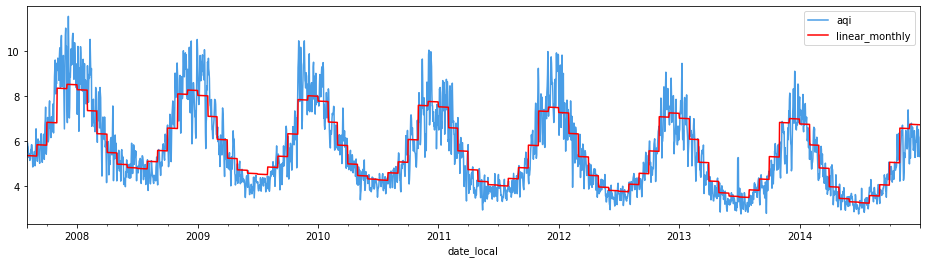

In [19]:
air_df[['aqi','linear_monthly']].loc[:'2014'].plot(color=['#499DE6','red']);

With this simple approach it is possible to separate the trend and seasonality components of the model.

<a id='t'></a>
### Trend

The coeffiecents for the monthly features indicate the seasonal effect they have.

<!-- *If it is February we add $-1.1$ to our predictions, if it's March we add $-2.2$, but if it's January we add 0.* -->

In [22]:
pd.DataFrame(
    columns = calendar.month_name[2:],
    data = [lm_monthly['model'].coef_[:-1]]
)

,February,March,April,May,June,July,August,September,October,November,December
0,-0.305921,2.931105,1.811113,2.715668,-0.643092,-0.622591,0.810096,-0.495098,2.73906,1.206909,0.195283


To isolate the trend we can replace the seasonal coefficients with their average.

In [23]:
average_seasonal_effect = lm_monthly['model'].coef_[:-1].sum()/12
average_seasonal_effect

0.8618775739603276

Using this average seasonal effect in the regression, inplace of the individual coefficients, allows us to get the trend line.

In [28]:
lm_monthly['model'].intercept_

5.671249797371533

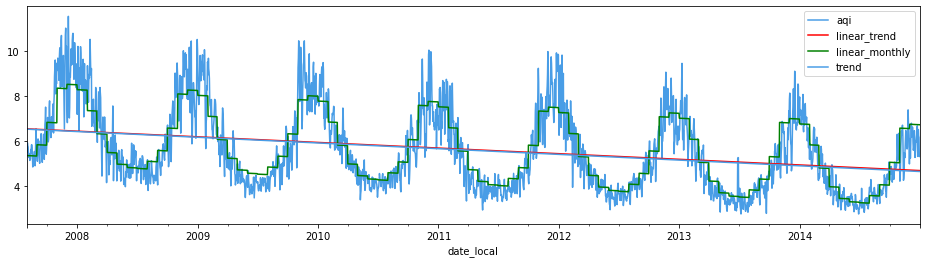

In [29]:
(
    air_df
    .assign(trend = lambda df: lm_monthly['model'].coef_[-1]*df['time_point'] 
                                + average_seasonal_effect 
                                + lm_monthly['model'].intercept_,
           )
    [['aqi', 'linear_trend', 'linear_monthly', 'trend']]
    .loc[:'2014']
    .plot(color=['#499DE6','red', 'green'])
);

<a id='s'></a>
### Seasonality

Subtracting the trend from the predictions allows us to separate the seasonality.

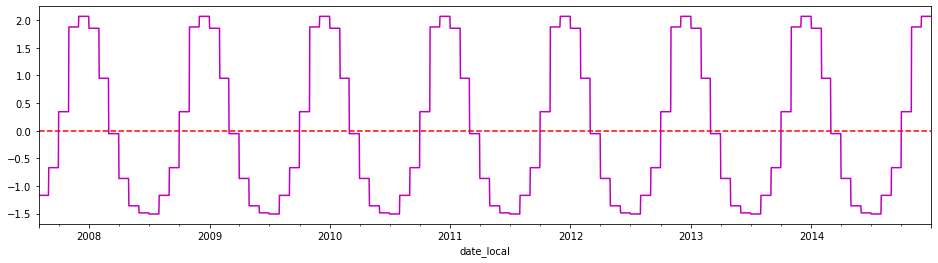

In [31]:
ax = (
    air_df
    .assign(residuals = lambda df: df['aqi'] - df['linear_monthly'],
            trend = lambda df: lm_monthly['model'].coef_[-1]*df['time_point'] 
                                + average_seasonal_effect 
                                + lm_monthly['model'].intercept_,
            seasonality = lambda df: df['linear_monthly']-df['trend']
           )
    ['seasonality']
    .loc[:'2014']
    .plot(c='m')
)
ax.axhline(0, color='r', linestyle='--');

Notice how we still have the seasonal waves but without the downwards trend.

This simple model with dummy features appears to reasonably capture the observed seasonality, even if it has limitations. For one, the model assumes fixed monthly jumps, while the actual seasonality is likely to be more complex.

<a id='gsf'></a>
## 4. Gradual Seasonal Filtering

Often seasonal effects do not come just as fixed spikes or drops. They may have gradually increasing and decreasing effects as their peak approaches and moves away in time. In such cases we may want to use a neater alternative to seasonal dummies: <font color='red'>gradual seasonal filters</font>.

There are a variety of such features that we could create. 

### Linear

A simple yet effective example are linear monthly spikes. They can be computed like so, 

$$ \phi(x_i) = \max( 1 - \frac{| x - x^*|}{n} , 0)$$

where $x$ is a given data point, $x^*$ is the peak of the current filter, and $n$ is the interval of growth/decline of the spike around the peak (e.g. 30 days). 

In [20]:
def gsf_feature_maker(center_day, days=np.arange(365), year_days=365, n=30):
    return np.maximum.reduce([
        np.fmax(-np.abs(days - center_day)/n + 1, 0),
        np.fmax(-np.abs(days + year_days - center_day)/n + 1, 0),  #ensures continuity across December-January
        np.fmax(-np.abs(days - year_days - center_day)/n + 1, 0) #ensures continuity across December-January
        ])

In [45]:
days=np.arange(365)
year_days=365
n=30
center_day=15

np.abs(days - center_day)/n + 1

array([ 1.5       ,  1.46666667,  1.43333333,  1.4       ,  1.36666667,
        1.33333333,  1.3       ,  1.26666667,  1.23333333,  1.2       ,
        1.16666667,  1.13333333,  1.1       ,  1.06666667,  1.03333333,
        1.        ,  1.03333333,  1.06666667,  1.1       ,  1.13333333,
        1.16666667,  1.2       ,  1.23333333,  1.26666667,  1.3       ,
        1.33333333,  1.36666667,  1.4       ,  1.43333333,  1.46666667,
        1.5       ,  1.53333333,  1.56666667,  1.6       ,  1.63333333,
        1.66666667,  1.7       ,  1.73333333,  1.76666667,  1.8       ,
        1.83333333,  1.86666667,  1.9       ,  1.93333333,  1.96666667,
        2.        ,  2.03333333,  2.06666667,  2.1       ,  2.13333333,
        2.16666667,  2.2       ,  2.23333333,  2.26666667,  2.3       ,
        2.33333333,  2.36666667,  2.4       ,  2.43333333,  2.46666667,
        2.5       ,  2.53333333,  2.56666667,  2.6       ,  2.63333333,
        2.66666667,  2.7       ,  2.73333333,  2.76666667,  2.8 

In practice, a filter like this translates into a variable with values the closer to 1 (or to 0), the closer (or the further) a particular date is from the given peak.

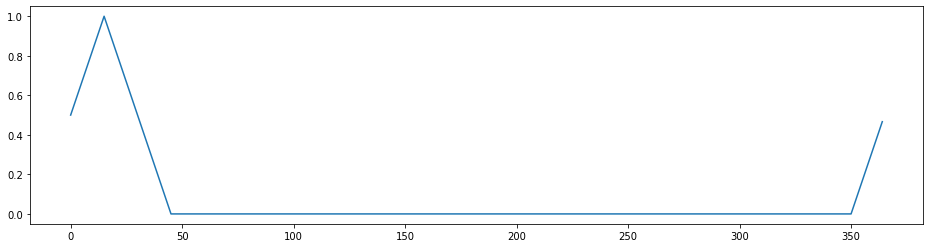

In [21]:
base = gsf_feature_maker(15)
plt.plot(base);

Such gradual filters could be especially handy when dealing with daily data that typically exhibits more gradual seasonal effects. 

A separate filter can be assigned to each potential seasonal peak — each month in the example below.

In [22]:
months_2008 = pd.date_range('2008-01-01', periods = 12, freq='MS')

month_peaks = pd.Series(
    index = months_2008.map(lambda data: data.month_name()),
    data = months_2008.map(lambda data: data.replace(day=15).dayofyear)
)

month_peaks.head()

January      15
February     46
March        75
April       106
May         136
dtype: int64

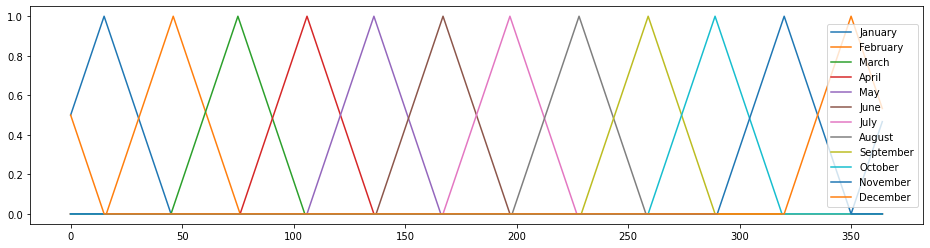

In [23]:
fig, ax = plt.subplots()
for month in month_peaks.index:
    peak = month_peaks.at[month]
    ax.plot(gsf_feature_maker(peak), label=month)
ax.legend(loc='right')

We can add this information as features and use it to model the Time Series data. 

It means that the effect is not felt uniformly across a month, but increases/decreases depending on the distance from the desginated centre.

In [24]:
X_gsf = air_df[['time_point']].copy()

days = X_gsf.index.dayofyear

for month in month_peaks.index:
    peak = month_peaks.at[month]
    X_gsf[month] = gsf_feature_maker(peak, days)
    
X_gsf.head()


,time_point,January,February,March,April,May,June,July,August,September,October,November,December
date_local,,,,,,,,,,,,,
2007-08-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.466667,0.500000,0.0,0.0,0.0,0.0
2007-08-02,1,0.0,0.0,0.0,0.0,0.0,0.0,0.433333,0.533333,0.0,0.0,0.0,0.0
2007-08-03,2,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.566667,0.0,0.0,0.0,0.0
2007-08-04,3,0.0,0.0,0.0,0.0,0.0,0.0,0.366667,0.600000,0.0,0.0,0.0,0.0
2007-08-05,4,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.633333,0.0,0.0,0.0,0.0


### Gaussian

Another commonly used option are filters based on a *Gaussian distribution*:

$$ \phi(x_i) = \exp [ - \frac{1}{2\alpha} (x-m_i)^2]$$

where $x$ is a given data point, $m_i$ is the peak of the current filter, and $\alpha$ is a parameter responsible for the spread of the distribution. 

In [25]:
def rbf_feature_maker(center_day, days=np.arange(365), year_days = 365, alpha = 0.005):
    return np.maximum.reduce([
        np.fmax(np.exp(-((days - center_day)**2) / 2*alpha), 0),
        np.fmax(np.exp(-((days + year_days - center_day)**2) / 2*alpha), 0), #ensures continuity for December-January
        np.fmax(np.exp(-((days - year_days - center_day)**2) / 2*alpha), 0)  #ensures continuity for December-January
        ]) 

Again, a filter like this translates into a variable with values the closer to 1 (or to 0), the closer (or the further) a particular date is from the given peak. However, the effect is much smoother.

Depending on $\alpha$, very steep or very gradual filters can be created.  Such gradual filters could be especially handy when dealing with daily (or even hourly) data that typically exhibits more gradual seasonal effects. 

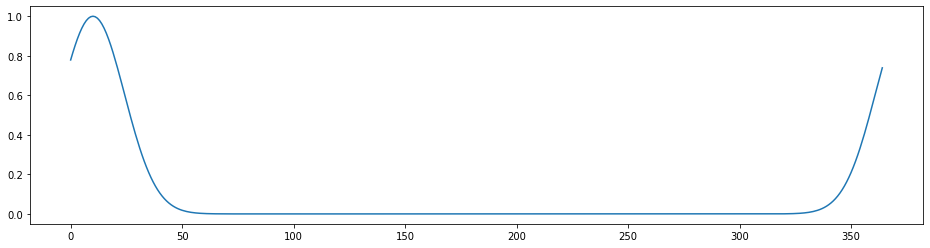

In [26]:
base = rbf_feature_maker(10, alpha = 0.005)
plt.plot(base);

### <mark>Exercise: Modelling with Gradual Seasonal Filters</mark>

Add Gaussian features that correspond to the different months and use them to help model the data. 
- How do the preditions compare visually to the model with seasonal dummy features?
- How is the performance affected by the $\alpha$ value?

In [27]:
# %load answers/rbf.py

### Gradual Seasonal Filtering summary

**Pros** 

- simple feature engineering trick
- all variables are interpretable
- seasonal effects can be quantified
- focus on filtering out the long term season, other fluctuations can be modeled separately

**Cons** 

- the model can get a bit biased 
- the model may have issues if the seasonality changes over time (fixable)

<a id='sum'></a>
## 5. Summary

Whilst modelling and forecasting time series data we have come across a few key points:
- Seasonality matters!
- Feature engineering is a way to turn your creativity into better models;
- There are many ways to identify it;
- Linear models are more powerful than people think.

Next steps:
- Alternative approaches to encoding seasonality, e.g fitting a sinusoidal curve.
- Alternative applications, e.g. outlier detection.
- Model evaluation.